In [1]:
import os
import shutil
from itertools import product

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pop_tools
import xpersist as xp

import dask
import util

In [2]:
#import plotting modules
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.colorbar import Colorbar 
from matplotlib import ticker, cm
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean
from matplotlib.ticker import FormatStrFormatter


## Spin up dask cluster

In [3]:
# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

In [4]:
# Setup your PBSCluster
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='10GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=10GB', # Specify resources
    project='NCGD0011', # Input your project ID here
    walltime='06:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(32)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/zephyrs/proxy/45443/status'})

# Setup your client
client = Client(cluster)
# Setup your PBSCluster - make sure that it uses the casper queue
cluster = PBSCluster(queue='casper')

/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/distributed/node.py:244: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35000 instead
  http_address["port"], self.http_server.port
/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/distributed/node.py:244: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43448 instead
  http_address["port"], self.http_server.port


# Load Data

In [5]:
ds_djf = xr.open_zarr(f'{util.project_tmpdir}/cesm-le-fields-djf.zarr')
ds_djf = ds_djf[['SST', 'Chl_surf', 'KGP']].sel(length = 40)
ds_djf

<xarray.Dataset>
Dimensions:    (member_id: 34, nlat: 93, nlon: 320, time: 180)
Coordinates:
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
    length     float64 40.0
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables:
    SST        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    Chl_surf   (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    KGP        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>

## Compute the properties of the climate



In [6]:
## Compute the properties of the unperturbed climate
# The mean
ds_ctrl_mean = (
        ds_djf.sel(time=slice(1920, 1950))
        .mean(dim=['time', 'member_id'])
        .compute()
)
    
# Standard deviation of anomalies
ds_ctrl_std = ( #data - mean of ref time
        (ds_djf - ds_djf.mean(dim=['member_id']).sel(time=slice(1920, 1950)))
        .std(dim=['time', 'member_id']) #take it's standard deviation
        .compute() #compute it
)

## Compute the properties of the current climate: 1990-2020
# The mean
ds_curr_mean = (
        ds_djf.sel(time=slice(1990, 2020))
        .mean(dim=['time', 'member_id'])
        .compute()
)

## Compute the properties of the future climate: 2070-2100
# The mean
ds_fut_mean = (
        ds_djf.sel(time=slice(2070, 2100))
        .mean(dim=['time', 'member_id'])
        .compute()
)

## Make it polar plottable

In [7]:
# Polar Plottable
dsp_gp = util.pop_add_cyclic(
    xr.Dataset({
        'ctrl': ds_ctrl_mean.KGP,
        'curr':ds_curr_mean.KGP,
        'stdev': ds_ctrl_std.KGP,
        'future':ds_fut_mean.KGP,
        'change': ds_fut_mean.KGP - ds_curr_mean.KGP,

        'TLAT': ds_djf.TLAT.compute(),
        'TLONG': ds_djf.TLONG.compute() } ))
#dsp_gp

### find the highest krill growth rate in both epochs:

In [8]:
print('current max gp rate:',np.round(dsp_gp.curr.max().values, 3), ', future max gp rate:',np.round(dsp_gp.future.max().values, 3))

current max gp rate: 0.218 , future max gp rate: 0.213


In [9]:
extent = ([-180, 180, -90, -50], ccrs.PlateCarree())
prj = ccrs.SouthPolarStereo()

future_gp = [0, dsp_gp.future.max().values]
current_gp = [0, dsp_gp.curr.max().values]

def bones(da, postive_growth):
    # contour lines: dc.where(dc>0)
    cf = ax.contour(dsp.TLONG, dsp.TLAT, da,
                    colors='k', 
                    levels=postive_growth,
                    linewidths=.5,
                    transform=ccrs.PlateCarree())
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                    colors='r', alpha=0.5, 
                    levels=postive_growth,
                    linewidths=1,
                    transform=ccrs.PlateCarree())    
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: linewidths is ignored by contourf
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


NameError: name 'decrease_a' is not defined

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


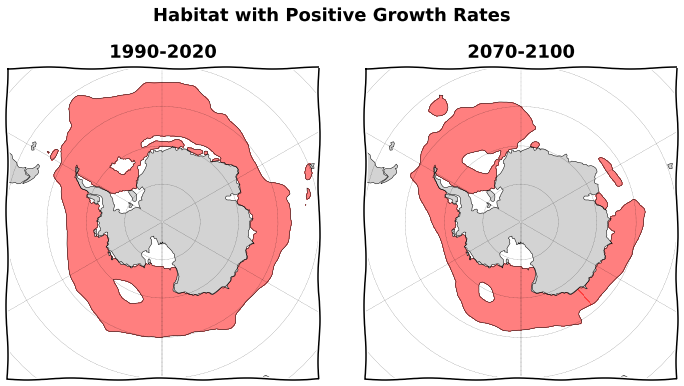

In [10]:
with plt.xkcd():
################### FIGURE SET-UP ##########################
    fig = plt.figure(figsize=(12, 12))
    gs = gridspec.GridSpec(2,2, height_ratios=[2,0.25], top=0.9, bottom=0.45, right=0.9, wspace = 0.15, hspace = 0.01)
    t1, t2, unit = '1990-2020', '2070-2100', 'mm day$^{-1}}$'
    dsp = dsp_gp
    fig.text(.5, .935,'Habitat with Positive Growth Rates', ha='center', fontsize = 18, fontweight = 'bold')
################### LEFT MOST PLOT: Current Mean ############################
    ax = fig.add_subplot(gs[0, 0], projection=prj)
    ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    ax.set_title(f'{t1}', fontsize = 18, fontweight = 'bold',pad=10)

    cf = bones(dsp.curr, current_gp)

################### MIDDLE PLOT: Future Mean ############################
    ax = fig.add_subplot(gs[0, 1], projection=prj)
    ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    ax.set_title(f'{t2}', fontsize = 18, fontweight = 'bold',pad=10)

    cf = bones(dsp.future, future_gp)

    fig.text(0.5, 0.495, f'Habitat with positive growth potential decreased by {np.round(decrease_a)} % ',ha='center')
    fig.text(0.5, 0.475, f'and the growth rate within the area also decreased by {np.round(decrease_r)} %',ha='center')


## In essence, you want to mask the TAREA array by the sign of KGP

###  TAREA has dimensions 'nlat', 'nlon', so you need to "broadcast" to get time.

Arrays with different sizes cannot be added, subtracted, or generally be used in arithmetic.

A way to overcome this is to duplicate the smaller array so that it is the dimensionality and size as the larger array. This is called array broadcasting and is available in NumPy when performing array arithmetic, which can greatly reduce and simplify your code.


The term **broadcasting** describes how numpy treats arrays with different shapes during arithmetic operations. Subject to certain constraints, the smaller array is “broadcast” across the larger array so that they have compatible shapes

In [12]:
kgp_positive = ds_djf.KGP.where(ds_djf.KGP > 0) # dims ---> 'time', 'nlat', 'nlon'
masked_area = ds_djf.TAREA.where(ds_djf.KMT > 0).fillna(0.)
kgp_positive_mean = (kgp_positive * masked_area).sum(['nlat', 'nlon']) / masked_area.sum()

In [13]:
kgp_positive_mean

<xarray.DataArray (time: 180, member_id: 34)>
dask.array<truediv, shape=(180, 34), dtype=float64, chunksize=(180, 1), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
    length     float64 40.0

In [14]:
## Compute the properties of the unperturbed climate
# The mean
past_r = (kgp_positive_mean.sel(time=slice(1920, 1950))
        .mean(dim=['time', 'member_id'])
        .compute())

present_r = (kgp_positive_mean.sel(time=slice(1990, 2020))
        .mean(dim=['time', 'member_id'])
        .compute())

future_r = (kgp_positive_mean.sel(time=slice(2070, 2100))
        .mean(dim=['time', 'member_id'])
        .compute())
decrease_r = (future_r.values-present_r.values)/past_r.values*100


In [15]:
print('past:', ['{:f}'.format(past_r.values)], 
     '\n present:', ['{:f}'.format(present_r.values)],
     '\n future:', ['{:f}'.format(future_r.values)],
     '\n percent change in growth rate', np.round(decrease_r, 3),'%')

past: ['0.009061'] 
 present: ['0.009003'] 
 future: ['0.006299'] 
 percent change in growth rate -29.846 %


### Area Comparrisons

In [16]:
kgp_area = ds_djf.TAREA * (ds_djf.KGP.where(ds_djf.KGP >0).fillna(0.)) # dims ---> 'time', 'nlat', 'nlon'
kgp_positive_timeseries = kgp_area.sum(['nlat', 'nlon'])

In [17]:
## Compute the properties of the unperturbed climate
# The mean
past_a = (kgp_positive_timeseries.sel(time=slice(1920, 1950))
        .mean(dim=['time', 'member_id'])
        .compute())

present_a = (kgp_positive_timeseries.sel(time=slice(1990, 2020))
        .mean(dim=['time', 'member_id'])
        .compute())

future_a = (kgp_positive_timeseries.sel(time=slice(2070, 2100))
        .mean(dim=['time', 'member_id'])
        .compute())
decrease_a = (future_a.values-present_a.values)/past_a.values*100

In [19]:
print('past:', ['{:f}'.format(past_a.values)], 
     '\n present:', ['{:f}'.format(present_a.values)],
     '\n future:', ['{:f}'.format(future_a.values)],
     '\n percent change in positive growth area', np.round(decrease_a, 3),'%'
     )

past: ['9840970216281702.000000'] 
 present: ['9777633665215796.000000'] 
 future: ['6840469128771457.000000'] 
 percent change in positive growth area -29.846 %


In [ ]:
for member_id in kgp_positive_timeseries.member_id.values:
    kgp_positive_timeseries.sel(member_id=member_id).plot()

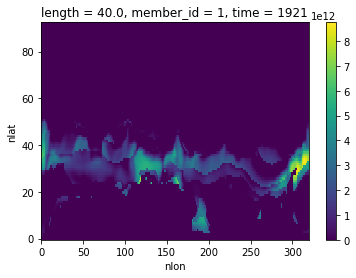

In [74]:
kgp_area.isel(time=0, member_id=0).plot()

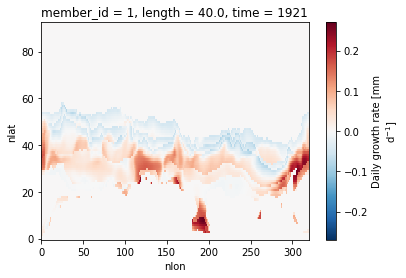

In [75]:
ds_djf.KGP.isel(time=0, member_id=0).plot()